<div style="padding: 35px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.pexels.com/photos/380337/pexels-photo-380337.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)"><b><span style='color:black'>Data Creator Camp Setting</span></b> </div>

#### **step 0.** GPU 연결을 위한 CUDA 설정
- NVIDIA Graphic Driver
- CUDA 11.8
- CuDNN 8.8

#### **step 1.** 가상환경 생성
- conda create --name DCC python=3.8 -y
- conda activate DCC

#### **step 2.** 관련 패키지 생성 (프롬프트에서 설치를 진행)
- pip install tensorflow==2.10.0
- pip install classification_models
- pip install image-classifiers (설치 이후 커널을 재시작한 뒤 Import를 수행해야 인식됨 / 이유는 아직 파악하지 못함)
- pip install tensorflow_addons
- pip install scipy
- pip install threadpoolctl
- pip install tqdm
- pip install pillow
- pip install seaborn
- pip install opencv-python

## Import

In [7]:
# Tensorflow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.client import device_lib

# for keras
from classification_models.keras import Classifiers

# model
import tensorflow_addons as tfa
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model, load_model

# image processing, callbacks
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report

# file
import zipfile
import os
import shutil

# sub
from tqdm import tqdm
import random

# basic
import pandas as pd
import numpy as np

# Plot
from PIL import Image
import matplotlib.pyplot as plt

## GPU 연결 확인 및 할당 메모리 제한

In [8]:
print(tf.__version__)
print(device_lib.list_local_devices())

2.10.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2430910370677605669
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14053015552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2103892834795321367
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:07:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


Tensorflow는 초기 학습 진행 시 사용이 가능한 메모리를 최대한으로 사용하도록 기본값이 설정됐기 때문에 메모리 할당량을 제한

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 11)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


## 제공 이미지 파일 압출풀기

In [10]:
zip_files = ['./데이터셋/kfood_train.zip', './데이터셋/kfood_val.zip', 
             './데이터셋/kfood_health_train.zip', './데이터셋/kfood_health_val.zip']

for zip_file in tqdm(zip_files):
    
    folder_name = os.path.splitext(os.path.basename(zip_file))[0]
    output_folder = os.path.join('./Kfood/', folder_name)
    os.makedirs(output_folder, exist_ok=True)
    
    # 폴더 이름에 포함된 한글 폰트를 위해 인코딩 수정
    if "health" in folder_name:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            for file_info in zip_ref.infolist():
                file_info.filename = file_info.filename.encode('cp437').decode('euc-kr')
                zip_ref.extract(file_info, output_folder)
    
    else:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(output_folder)

100%|██████████| 4/4 [01:06<00:00, 16.54s/it]


## MISSION 1. 한국 이미지(음식) 데이터셋을 분류하시오

### 1-1 각 메뉴를 클래스로 하는 분류 데이터셋과 데이터로더를 준비, 예시 이미지를 클래스별로 하나씩 시각화

#### 데이터 로더 준비

In [11]:
# 데이터 폴더 경로 설정
train_data_dir = './Kfood/kfood_train/train/'  # Train
val_data_dir = './Kfood/kfood_val/val/' # Validation

all_items = os.listdir(train_data_dir)
num_classes = len(all_items)

In [12]:
# 이미지 크기 설정
img_width, img_height = 224, 224

# Data Generator 설정 (미션 1의 경우 resnet18의 구조만을 사용, 이 외의 경우는 사용하지 않는 것으로 간주해 해당 단계에선 정규화만 진행)
train_datagen = ImageDataGenerator(
    rescale=1. / 255, # 이미지 값을 0과 1 사이로 정규화
)

In [13]:
# 데이터 로딩 및 전처리
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical', # 다중 클래스 분류를 위해 categorical로 설정  
)

validation_generator = train_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical')

Found 33593 images belonging to 42 classes.
Found 4198 images belonging to 42 classes.


#### 클래스 별 42장의 이미지를 한 번에 시각화

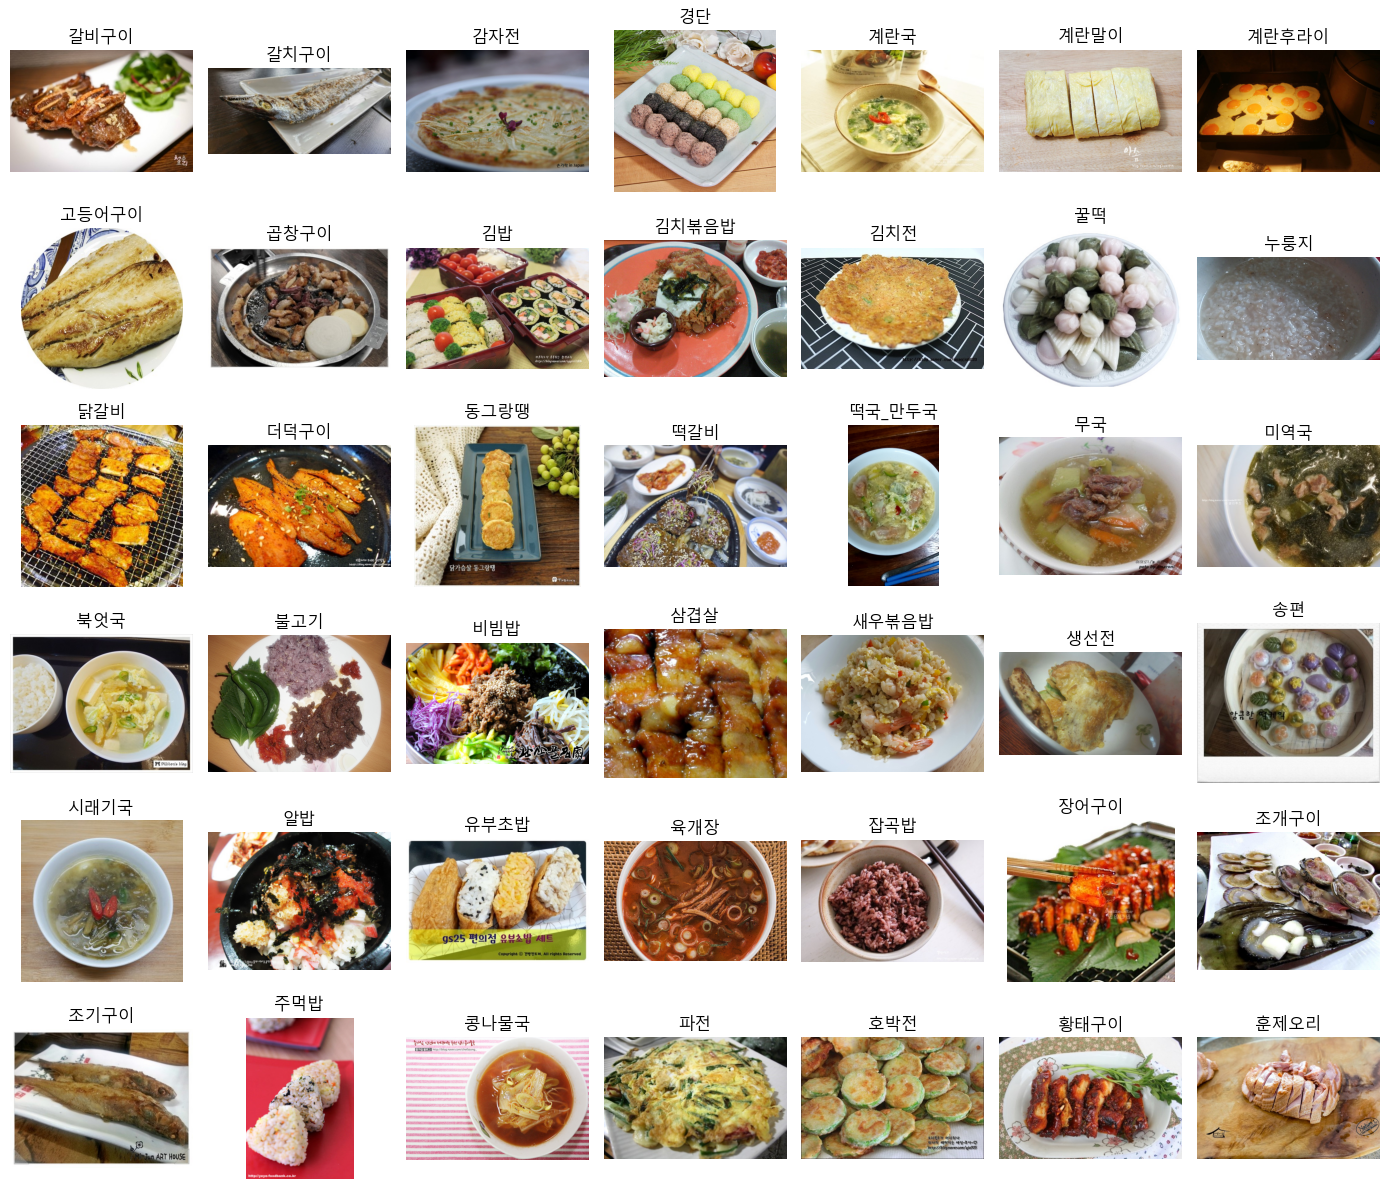

In [12]:
plt.rcParams['font.family'] = 'Malgun Gothic'

rows, cols = 6, 7  # 행과 열의 개수 설정
fig, axes = plt.subplots(rows, cols, figsize=(14, 12))

for i, folder_name in enumerate(all_items):
    folder_path = os.path.join(train_data_dir, folder_name)
    
    # 폴더 내의 모든 이미지 파일을 가져옵니다.
    image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
    
    if image_files:
        # 랜덤하게 이미지 1장 선택
        random_image = random.choice(image_files)
        random_image_path = os.path.join(folder_path, random_image)
        
        # 이미지를 행렬로 변환
        image = Image.open(random_image_path)
        image_array = np.array(image)
        
        # 이미지를 해당 위치의 축에 배치
        row_idx, col_idx = i // cols, i % cols
        axes[row_idx, col_idx].imshow(image_array)
        axes[row_idx, col_idx].set_title(f"{folder_name}")
        axes[row_idx, col_idx].axis('off')  # 축 숨기기

# 불필요한 축 제거
for i in range(len(all_items), rows * cols):
    row_idx, col_idx = i // cols, i % cols
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

### 1-2 ResNet18를 활용하여 42종의 클래스 분류를 수행하고 Validation 데이터에 대한 정확도를 제시

In [14]:
# keras Classifiers에서 제공되는 모델 목록 확인
model_list = Classifiers.models_names()
model_list

['resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'seresnet18',
 'seresnet34',
 'seresnet50',
 'seresnet101',
 'seresnet152',
 'seresnext50',
 'seresnext101',
 'senet154',
 'resnet50v2',
 'resnet101v2',
 'resnet152v2',
 'resnext50',
 'resnext101',
 'vgg16',
 'vgg19',
 'densenet121',
 'densenet169',
 'densenet201',
 'inceptionresnetv2',
 'inceptionv3',
 'xception',
 'nasnetlarge',
 'nasnetmobile',
 'mobilenet',
 'mobilenetv2']

In [17]:
# API를 사용해 Resnet18 모델 load
ResNet18, preprocess_input = Classifiers.get('resnet18')
resnet18_model = ResNet18((img_height, img_width, 3), 
                 activation = 'softmax',
                 pretrained = False, # 미리 학습된 사전학습 가중치를 사용 X
                 include_top = False, # 기본 APi 모델의 출력 레이어는 유닛이 1,000개 이므로 해당 부분도 사용 X
                 pretrained_top = False, # 모델의 상단 부분에 사전학습된 가중치 또한 사용 X
                 classes = num_classes)

In [18]:
# 모델 출력 레이어 수정
model = models.Sequential()
model.add(resnet18_model)
model.add(layers.Flatten())
model.add(layers.Dense(42, activation='softmax'))

In [21]:
# 모델 optimizer 설정 및 compile
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0), 
              metrics = [tf.keras.metrics.TopKCategoricalAccuracy(k=1)]) # Top-1 ACC

In [ ]:
# 체크포인트 파일 경로 및 설정
checkpoint_filepath = './Checkpoint/Mission1.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,  # 최상의 모델만 저장
    monitor='val_top_k_categorical_accuracy',  # 모니터링할 지표
    mode='max',  # 해당 문제가 얼마나 잘 분류했는지를 확인하는 것이므로 ACC가 최선일 때로 저장
    verbose=1
)

# 모델을 학습할 때 ModelCheckpoint 콜백을 지정
with tf.device('/device:GPU:0'): 
    model.fit(
        train_generator,
        epochs=50,
        verbose=1,
        validation_data=validation_generator,
        callbacks=[model_checkpoint_callback]
    )

검증 데이터에 대한 채점 진행에서 tensorflow코드를 확인받지 못해 classification report로 임시 대체하겠습니다.

In [ ]:
# 체크포인트 파일 경로
checkpoint_filepath = './Checkpoint/Mission1.h5'

# 모델 로드
loaded_model = load_model(checkpoint_filepath)

# 검증을 위한 데이터 제너레이터 설정
val_data_dir = './Kfood/kfood_val/val/' 

# 이미지 크기 설정
img_width, img_height = 224, 224
validation_datagen = ImageDataGenerator(rescale=1.0 / 255) 

validation_generator = validation_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 4198 images belonging to 42 classes.


In [8]:
with tf.device('/device:GPU:0'): 
    validation_predict = loaded_model.predict(validation_generator)

validation_pred_classes = np.argmax(validation_predict,axis=1)

# classification report 출력
target_names = list(validation_generator.class_indices.keys())

validation_results = pd.DataFrame(classification_report(validation_generator.classes, validation_pred_classes, target_names=target_names, output_dict=True)).transpose()
print(validation_results)

4198/4198 [==============================] - 18s 4ms/step
              precision    recall  f1-score      support
갈비구이           0.150000  0.423529  0.221538    85.000000
갈치구이           0.555556  0.050505  0.092593    99.000000
감자전            0.195266  0.333333  0.246269    99.000000
경단             0.296296  0.170213  0.216216    94.000000
계란국            0.495413  0.556701  0.524272    97.000000
계란말이           0.425926  0.209091  0.280488   110.000000
계란후라이          0.225941  0.545455  0.319527    99.000000
고등어구이          0.283019  0.161290  0.205479    93.000000
곱창구이           0.538462  0.203883  0.295775   103.000000
김밥             0.690476  0.261261  0.379085   111.000000
김치볶음밥          0.132867  0.581633  0.216319    98.000000
김치전            0.666667  0.173913  0.275862   115.000000
꿀떡             0.836735  0.394231  0.535948   104.000000
누룽지            0.325000  0.397959  0.357798    98.000000
닭갈비            0.180556  0.611765  0.278820    85.000000
더덕구이           0.440678  0.273